In [1]:
#!pip install  nbconvert[webpdf]
import nbconvert

$\textbf{Introduction:  Exploring Exchange Rate Volatility with Machine Learning}$

In this notenbook I will explore the calculation of volatility with traditional and Machine Learning methods, including Simulated Annealing,  Particle Swarm Optimization, and the Genetic Algorithm,  as well as adaptations of the Quasi-Newton methods.   

We will also use traditional measures of conditional volatility from GARCH estimation (GCV) and the Gelman-Klass method of calculated Range Volatility (GKRV).  We compare these measures with those given by estimated Stochastic Volatility Jump Diffusion (SVJD) models.

The basic point is that the traditional GARCH model does not give much information about the underlying latent volatility process.  There are shocks to uncertainty as well as infrequent jumps in the data.  By ignoring these additional stochastic processes in the underlying data generating process, the GARCH specification is much less informative that these more complex methods.

This paper will examine the Euro/Dollar exchange rate with daily data spanning twenty years.  

We first compare the rate itself, then in log fisrt differences, then we calculate the Range Volatility from daily information on open, close, high and low values.  Finally we examine the GARCH outcomes.  The point of all of this is that there is more to the story.

Then I examine the Stochastic Volatility Jump Diffusion (SVJD) model.  This was introduced by Bates (1996) [David S. Bates, "Jumps and Stochastic volatility: Exchange Rate Processes Implicity in Deutsche Mark Options", The Review of Financial Studies, volume 9, number 1, 1996, pages 69–107.].  It has been used for option pricing.  But our purpose is more modest:  simply to extract the underlying latent volatility process.

We then discuss the options for estimating the parameters of this model:  log-likelihood maximization and Generalized Method of Moments.  

Since these estimation processes involve considerable complexity, we discuss both global search as well as local gradient-based methods for obtaining the results.





$\textbf{Importing the Data from Yahoo Finance}$

We first import the high, low, open and closing series from Yahoo Finance.  Althgh we request the data to start is 2000,
we can only obtain data from 2003-12-01.  You may need to install yfinance



C:\Users\mcnel\anaconda4\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\mcnel\anaconda4\lib\site-packages\pandas\core\arrays\masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


        Date      Open      High       Low     Close  Adj Close  Volume
0 2004-01-01  0.018103  0.018103  0.018103  0.018103   0.018103       0
1 2004-01-02  0.018038  0.018049  0.018038  0.018049   0.018049       0
2 2004-01-05  0.018075  0.018126  0.018075  0.018086   0.018086       0
3 2004-01-06  0.018175  0.018232  0.018164  0.018232   0.018232       0
4 2004-01-07  0.018164  0.018212  0.018132  0.018212   0.018212       0


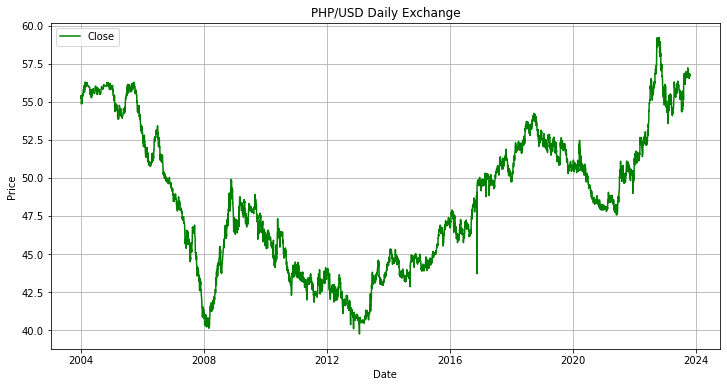

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

import yfinance as yf
import pandas as pd

# Define the currency pair symbol




# Define the currency pair symbol (CNY/USD) and date range
currency_pair = "PHPUSD=X"  # Yahoo Finance symbol for CNY/USD
start_date = "2004-01-01"
end_date = "2023-10-20"

# Fetch historical data
ph_data = yf.download(currency_pair, start=start_date, end=end_date, progress=False)

# Reset the index to access date as a column
ph_data.reset_index(inplace=True)

# Access the 'Date' column
date = ph_data['Date']

# Print the first few rows of the 'Date' column
print(ph_data.head())

open_price = 1/ph_data['Open']
high_price = 1/ph_data['High']
low_price = 1/ph_data['Low']
close_price = 1/ph_data['Close']
close_adj_price = 1/ph_data['Adj Close']
high = high_price
low = low_price
close = close_adj_price
open = open_price
#threshold = 6

# Replace low/high values below the threshold with the previous value
#high = high.mask(high < threshold).ffill()
#close = high.mask(close < threshold).ffill()
#low = high.mask(low < threshold).ffill()



# Plot the data
plt.figure(figsize=(12, 6))
#plt.plot(date, close, label='Open', color='blue')
plt.plot(date, close_adj_price, label='Close', color='green')
#plt.plot(date, high, label='High', color='red')
#plt.plot(date, low, label='Low', color='orange')
plt.title('PHP/USD Daily Exchange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


We now calculate the log-first differences of the series.  Note that we have to start the date vector one period later since we lost an observation.

In [2]:
import numpy as np
close_price = np.array(close_price)
#eurus_diff = np.diff(np.log(close_price))
phus_diff =   np.diff(np.log(close_adj_price))
#close_price = close_price.interpolate(method='linear')
#eurus_diff1 = close_price.pct_change().dropna()
#close_price1 = close_price.iloc[:,1]
phus_diff2 = np.log(close_adj_price[1:]/close_adj_price[:-1])


Text(0.5, 1.0, 'Daily Rate of Change of PH/USD Closing Price')

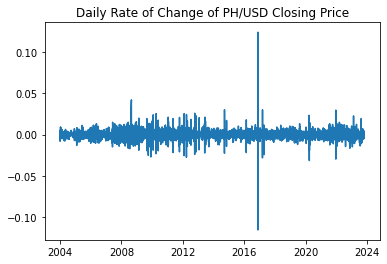

In [3]:
plt.plot(date[1:], phus_diff)
plt.title('Daily Rate of Change of PH/USD Closing Price')

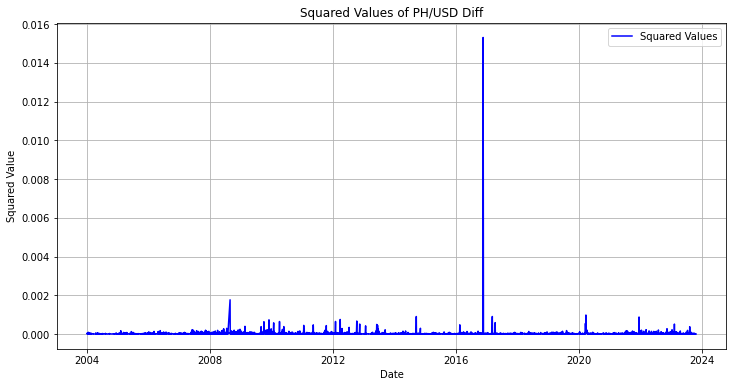

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming eurus_diff2 is a NumPy array or list of values


# Square each element of the vector
phus_diff_sq = np.square(phus_diff)

# Assuming date[1:] corresponds to the dates for the entire dataset
dates = date[1:]

# Plot the squared values
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(dates, phus_diff_sq, label='Squared Values', color='blue')

# Customize the plot as needed (e.g., labels, title, legend, etc.)
plt.xlabel('Date')
plt.ylabel('Squared Value')
plt.title('Squared Values of PH/USD Diff')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


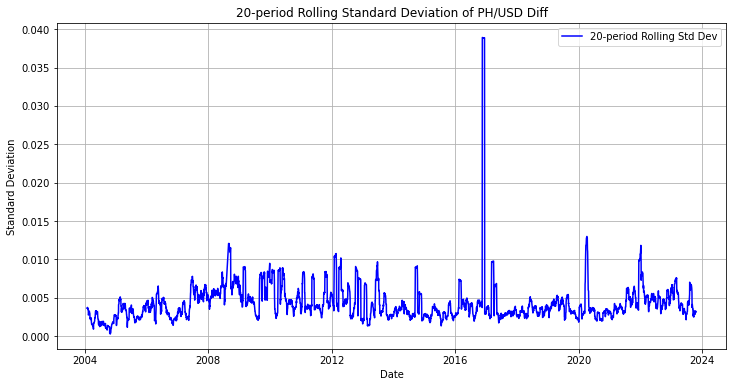

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'date' is a list or array of dates and 'eurousdiff' is the corresponding series
# Convert them to a Pandas DataFrame
df = pd.DataFrame({'Date': date[1:], 'PHUS': phus_diff})

# Calculate the 20-period rolling standard deviation for the 'Euro' column
rolling_std = df['PHUS'].rolling(window=20).std()

# Plot the rolling standard deviation
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(df['Date'], rolling_std, label='20-period Rolling Std Dev', color='blue')

# Customize the plot as needed (e.g., labels, title, legend, etc.)
plt.xlabel('Date')
plt.ylabel('Standard Deviation')
plt.title('20-period Rolling Standard Deviation of PH/USD Diff')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [6]:
import numpy as np

def count_jumps_and_average_jump_size(data, threshold):
    num_jumps = 0
    total_jump_size = 0  # To calculate the total jump size

    for i in range(1, len(data)):
        jump_size = abs(data[i] - data[i - 1])
        if jump_size > threshold:
            num_jumps += 1
            total_jump_size += jump_size

    if num_jumps > 0:
        average_jump_size = total_jump_size / num_jumps
    else:
        average_jump_size = 0  # To handle the case with no jumps

    pnum_jumps = num_jumps/len(data)

    return pnum_jumps, average_jump_size

# Example usage:


In [7]:
data = np.diff(np.log(close_adj_price))

threshold = 2.576 * np.std(data)
pnum_jumps, average_jump_size = count_jumps_and_average_jump_size(data, threshold)

print("% Percentage of number of jumps:", pnum_jumps)
print("Average jump size:", average_jump_size)
print('threshold',threshold)



% Percentage of number of jumps: 0.05184174624829468
Average jump size: 0.0225959744711905
threshold 0.013301953943271206


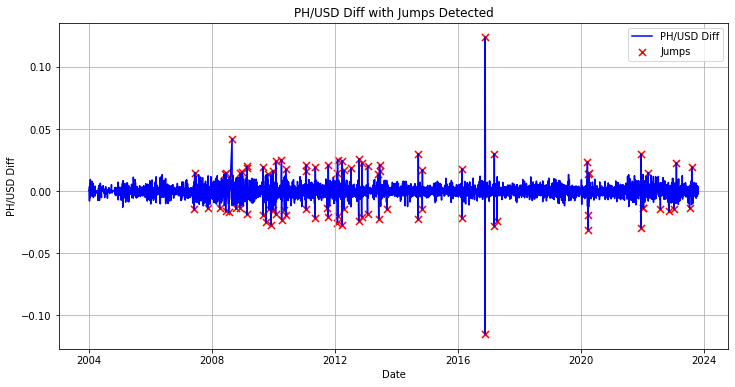

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'date' is a list or array of dates and 'eurousdiff' is the corresponding series
# Convert them to a Pandas DataFrame
df = pd.DataFrame({'Date': date[1:], 'PHUS': phus_diff})

# Set a threshold for identifying jumps (you can adjust this threshold)

# Calculate the absolute differences between consecutive data points
absolute_changes = df['PHUS'].abs()

# Identify jumps by comparing with the threshold
jumps = absolute_changes > threshold

# Plot the 'Euro' series
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
plt.plot(df['Date'], df['PHUS'], label='PH/USD Diff', color='blue')

# Plot jumps as red markers
plt.scatter(df['Date'][jumps], df['PHUS'][jumps], c='red', label='Jumps', marker='x', s=50)

# Customize the plot as needed (e.g., labels, title, legend, etc.)
plt.xlabel('Date')
plt.ylabel('PH/USD Diff')
plt.title('PH/USD Diff with Jumps Detected')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


$\textbf{Garman-Klass Range Volatility Measure}$

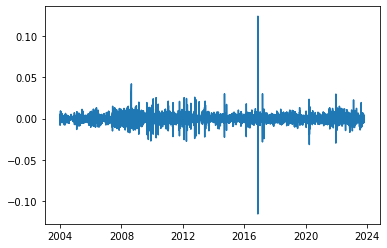

In [9]:
plt.plot(date[1:],phus_diff)

In [10]:
import numpy as np
rangevol1 =  (np.log(high)-np.log(low))**2 - (2*np.log(2)-1)*(np.log(close)-np.log(open));
window_size = 30

# Calculate the rolling window average
rangevol = np.convolve(rangevol1, np.ones(window_size) / window_size, mode='valid')
rangevol = rangevol/rangevol[0]

# Print the rolling average
print(len(rangevol))
print(len(date[window_size-1:]))
rangevol_norm = (rangevol-np.min(rangevol))/(np.max(rangevol)-np.min(rangevol))

5103
5103


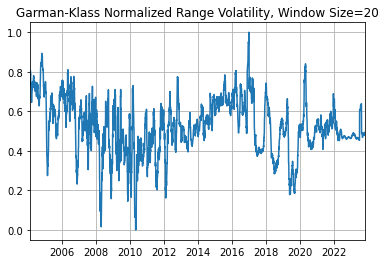

In [11]:
plt.plot(date[window_size-1:], rangevol_norm)
plt.title('Garman-Klass Normalized Range Volatility, Window Size=20')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

$\textbf{EGARCH Estimation with AR Term}$
We will do an EGARCH estimation with a lagged term in the mean equation.  The exponential general autoregressive conditional heteroskedastic (EGARCH) is another form of the GARCH model. E-GARCH model was proposed by Nelson (1991) to overcome the weakness in GARCH handling of financial time series. In particular, to allow for asymmetric effects between positive and negative asset returns.

The disadvantage of this approach is that the volatility is a function of the prediction errors for the exptected returns.  There are no independent shocks to the volatility process itself.

There are a number of other ARCH/GARCH options available with the arch library.
Here they are:  
In the arch package in Python, when specifying the vol argument in the arch_model function, you can choose from various volatility models to model the conditional variance of financial time series. Here are some of the available options for the vol argument:

'Garch': This is the standard Generalized Autoregressive Conditional Heteroskedasticity (GARCH) model, where the conditional variance is modeled as a linear function of lagged squared returns and lagged squared conditional variances.

'EGarch': This stands for Exponential Generalized Autoregressive Conditional Heteroskedasticity (EGARCH) model. In the EGARCH model, the conditional variance is modeled as an exponential function of lagged returns, lagged absolute returns, and lagged conditional variances.

'GJR' or 'Garch11': This is the GARCH(1,1) model, a specific variant of the GARCH model where the conditional variance depends on lagged squared returns and lagged squared conditional variances.

'Garchpq': You can specify your own order for the GARCH model by using 'Garchpq', where p and q are integers specifying the order of the GARCH model.

'Harch': The Heterogeneous Autoregressive Conditional Heteroskedasticity (HARCH) model allows for time-varying parameters in the conditional variance.

'Constant': This option specifies a constant volatility model, where the conditional variance is constant over time.

'Expanding': The expanding window volatility model is a rolling window volatility estimate.

'FixedSmoothing': Fixed smoothing volatility model allows you to specify a fixed smoothing parameter for volatility estimation.

'GarchRolling': GARCH rolling window volatility model.

'RiskMetrics': The RiskMetrics model is a volatility model based on exponentially weighted moving averages.

'Tarch': The Threshold GARCH (T-GARCH) model allows you to specify a threshold above which the conditional variance behaves differently.

These are some of the commonly used volatility models available in the arch package. You can choose the one that best suits your modeling needs based on the characteristics of your financial time series data.







In [12]:
#!pip install arch
import arch

import numpy as np
import pandas as pd
import arch






y = 100* phus_diff
model = arch.arch_model(y, vol='EGarch', p=1, q=1, dist='StudentsT', mean='ARX', lags=1)

# Fit the GARCH model
results = model.fit(options={'maxiter': 5000})
# Print the model summary
print(results.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 82428.45802172547
Iteration:      2,   Func. Count:     21,   Neg. LLF: 88184.85499548833
Iteration:      3,   Func. Count:     35,   Neg. LLF: 81014.21688729104
Iteration:      4,   Func. Count:     46,   Neg. LLF: 101220.65123160227
Iteration:      5,   Func. Count:     57,   Neg. LLF: 4603.72655166494
Iteration:      6,   Func. Count:     65,   Neg. LLF: 2627.9522819737954
Iteration:      7,   Func. Count:     73,   Neg. LLF: 2486.044714839145
Iteration:      8,   Func. Count:     81,   Neg. LLF: 5529.314140250562
Iteration:      9,   Func. Count:     89,   Neg. LLF: 2469.666823771079
Iteration:     10,   Func. Count:     97,   Neg. LLF: 2467.803598657608
Iteration:     11,   Func. Count:    105,   Neg. LLF: 2449.8807432073904
Iteration:     12,   Func. Count:    113,   Neg. LLF: 2437.242202876703
Iteration:     13,   Func. Count:    121,   Neg. LLF: 2436.1924860900663
Iteration:     14,   Func. Count:    128,   Neg. LLF: 2436.19

C:\Users\mcnel\anaconda4\lib\site-packages\arch\univariate\base.py:1888: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(val[pos], np.float64):
C:\Users\mcnel\anaconda4\lib\site-packages\arch\univariate\base.py:1889: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  converted = format_float_fixed(val[pos], *formats[i])


5130
5111


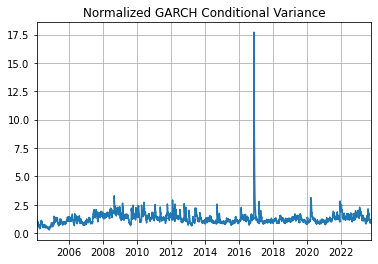

In [13]:
ConVar = results.conditional_volatility

window_size = 20

# Calculate the rolling window averag
ConVar = ConVar[1:]
ConVar1 = np.convolve(ConVar, np.ones(window_size) / window_size, mode='valid')


ConVar1 = ConVar/ConVar[0]
# Print the rolling average
print(len(ConVar1))

date2 = date[2:]
print(len(date2[window_size-1:]))
plt.plot(date2[window_size-1:], ConVar1[window_size-1:])
plt.title("Normalized GARCH Conditional Variance")
plt.grid(True)
plt.autoscale(axis='x', tight=True)

In [14]:
print(len(date))
print(len(rangevol_norm))

5132
5103


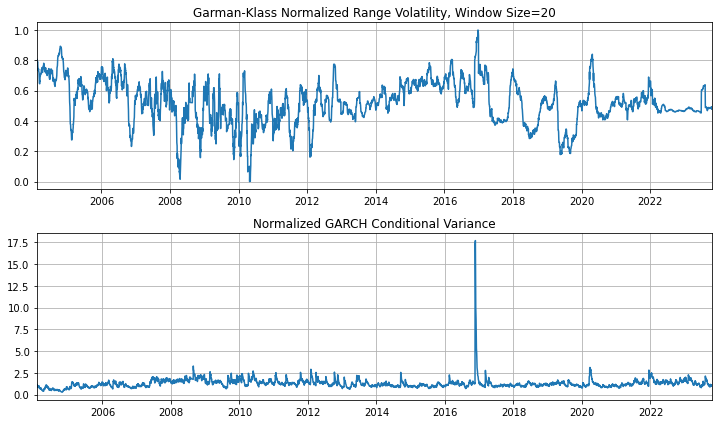

In [15]:

fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot the first graph in the top subplot
axs[0].plot(date[29:], rangevol_norm)
axs[0].set_title('Garman-Klass Normalized Range Volatility, Window Size=20')
axs[0].grid(True)
axs[0].autoscale(axis='x', tight=True)




# Plot the second graph in the bottom subplot
date2 = date[2:]
axs[1].plot(date2[window_size-1:], ConVar1[window_size-1:])
axs[1].set_title("Normalized GARCH Conditional Variance")
axs[1].grid(True)
axs[1].autoscale(axis='x', tight=True)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

We see that the conditional volatility is less volatile that the Range Volatility measure shows a lot less action than the GK measure following the GFC period in 2008 and 2009.

$\textbf{The Bates Stochastic Volatility Jump Diffusion Model}$


This model has the following continuous time representation:

$dW_{1,t} \sim \mathcal{N}(0,dt)$

$dN_t \sim \mathcal{P}(\lambda)$

$J_t \sim  \mathcal{N}(\mu_J, \sigma_J^2)$

$dS_t = rS_tdt + \sqrt{V_t}dW_{1,t}+ J_tdN_t$

$dW_{2,t} = \rho dW_{1,t} +\sqrt{1-\rho^2}\mathcal{N}(0,dt)$

$dV_t = \kappa (\theta-V_t)dt + \sigma\sqrt{V_t}dW_{2,t}$

$ Corr(dW_{1,t},dW_{2,t})  = \rho $

with the following terms:

dt:  unit of time, for daily data, dt= 1/252

$dW_{1,t}, dW_{2,t}$:  Normally distributed shocks to the mean return and volatility

$\mathcal{P}(\lambda)$:  Poisson shock with intensity $\lambda$

$J_t$:   Jump size, normally distributed with mean $\mu_t$ and variance $\sigma_J$

r:  risk free rate

$dS_t$; rate of return

$dV_t$ rate of change of the stochastic volatility, with restriction $V_t \ge 0$.

$\kappa$: mean-reversion coefficient of the stochastic volatility

$\theta$:  long-term stochastic volatility

$\sigma$: standard deviation of the process for stochastic volatility

$\rho$: correlation of the shocks to stochastic volatility and to returns, with the restriction:  $-1<\rho<1$

$V_0$: initial value for stochastic volatility, set equal to $\theta$

Our goal is to go behond the conditional variance of the GARCH, which only depends on the mean prediction errors, to a progress which has correlated shocks to the underlying mean and volatility processes.  From our observations on the daily rate of return, we thus wish to estimate five parameters.

The advantage of continuous time notation is that it is easy to shift estimation from daily to weekly or monthly data by changing the values of dt.




$\textbf{Issues for Empirical Implementation}$

- Issue: we need to select how we minimize a function
- But what is our accuracy measure?  
- This is our first choice or hyperparameter decision: how to we optimize a function
- What function, a likelihood function or Generalized Method of Moments estimation?
- Pros and cons of each.
- We have several choices: global vs. local methods, gradient vs stochastic search methods
- We also have to come to terms with non-convex error functions, there may be several local minima or saddle points
- The search for better optimization methods for nonlinear functions predates Machine Learning
- But Machine Learning or Computational Learning has contributed to this research agenda.



$\textbf{Estimation Objective}$


With various methods, we can have the objective of maximizing the Maximum Likelihood (ML) or, with the Generalized Method of Moments (GMM), minimizing the squared difference between key moments of the actual and simulated data of the model.

Maximum likelihood imposes the restriction of nomrally distributed shocks to the model. The ML method simply calculates the differences between the actual and predicted returns as well as the variance:

$\hat{\epsilon}_t = dS_t- \hat{dS}_t$

$\hat{\sigma}^2 = \frac{\sum_{t=1}^{N} \hat{\epsilon}_t^2}{N - k}$

and maximizes the log-likelihood function:

$\ln(\mathcal{L}) =  -N .5 \pi \sigma - .5 \Sigma (\frac{\hat{\epsilon}_t}{\sigma})^2$

where N is the number of observations and k is the number of parameters to be estimated. In our case, k=5.

The other method is the Generalized Method of Moments.  We simply calculate many moments of the actual and simulated data,
such as the first through fourth moments, for the mean, variance, skewness, and kurtosis.  We also calculate the autocorrelations of both actual data and simulated data, as well as the same autocorrelations of the squared values of the acutal and simulated data.  We also calculate the number of jumps and average size of the jumps in the actual and simulated data sets as additional moments. We them calculate the sum of squared differences beteen the moments of the actual and simulated data.











$\textbf{Local Gradient-Based Search:  The Quasi-Newton Method and Backpropagation}$

To minimize any non-linear function, we usually begin by ”initializing”  the parameter vector $\Omega$ at any initial value, $\Omega_{0}$,perhaps at randomly chosen values. We then ”iterate” on the coefficient set $\Omega$ until an error metric $ \Psi$ is minimized, by making use of first and second-order derivatives of the ”error metric” $\Psi$  with respect to the parameters.  This type of search, called a ”gradient-based search”, is for the optimum ”in the neighborhood” of the initial parameter vector, $\Omega_{0}$  For this reason, this type of search is a ”local” search.

The usual way in which one goes about doing this iteration is through the quasi-Newton algorithm. Starting with the initial set of sum of squared errors, $\Psi(\Omega_{0})$, based on the initial coefficient vector $\Omega_{0}$, a second-order Taylor expansion is used to find $\Psi(\Omega_{1}):\Psi(\Omega_{1})=\Psi(\Omega_{0})+\nabla_{0}(\Omega_{1}-\Omega_{0})+.5(\Omega_{1}-\Omega_{0})^{\prime}H_{0}(\Omega_{1}-\Omega_{0})$

where $\nabla_{0}$ is the gradient of the error function with respect to the parameter set $\Omega_{0}$ and $H_{0\text{ }}$ is the Hessian of the error function.

Letting $\Omega_{0}=[\Omega_{0,1},...\Omega_{0,k}]$, be the initial set of k parameters used in the network, the gradient vector $\nabla_{0}$ is defined as follows:

$\nabla_{0}=\left(\begin{array}{c}
\frac{\Psi(\Omega_{0,1}+h_{1},...\Omega_{0,k})-\Psi(\Omega_{0,1},...\Omega_{0,k})}{h_{1}}\\
\frac{\Psi(\Omega_{0,1}...\Omega_{0,i}+h_{i}...,\Omega_{0,k})-\Psi(\Omega_{0,1},...\Omega_{0,k})}{h_{i}}\\
.\\
.\\
\frac{\Psi(\Omega_{0,1},...\Omega_{0,i}..\Omega_{0,k}+h_{k})-\Psi(\Omega_{0,1},...\Omega_{0,k})}{h_{k}}
\end{array}\right)$

The denominator $h_{i}$  is usually set at max($\epsilon$,$\epsilon$$\Omega_{0,i})$,with $\epsilon=10^{-6}$.

The Hessian $H_{0}$ is the matrix of second-order partial derivatives of $\Psi$ with respect to the elements of $\Omega_{0}$, and are computed in a similar matter as the Jacobian or gradient vector.  The cross-partials or off-diagonal elements of the matrix $H_{0\text{ }}$ are given by the formula:

$\frac{\partial^{2}\Psi}{\partial\Omega_{0,i}\partial\Omega_{0,j}}=\frac{1}{h_{j}h_{i}}\left[\begin{array}{c}
\{\Psi(\Omega_{0,1},...,\Omega_{0,i}+h_{i},\Omega_{0,j}+h_{j},...\Omega_{0,k})-\Psi(\Omega_{0,1}...\Omega_{0,i,...}\Omega_{0,_{j}}+h_{j}...\Omega_{0,k})\}\\
-\{\Psi(\Omega_{0,1},...,\Omega_{0,i}+h_{i},\Omega_{0,j},...\Omega_{0,k})-\Psi(\Omega_{0,1},...\Omega_{0,k})\}
\end{array}\right]$

The direct second-order partials or diagonal elements are given by:

$\frac{\partial^{2}\Psi}{\partial\Omega_{0,i}^{2}}=\frac{1}{h_{i}^{2}}\left(\begin{array}{c}
\Psi(\Omega_{0,1},...,\Omega_{0,i}+h_{i},...\Omega_{0,k})-2\Psi(\Omega_{0,1},...\Omega_{0,k})\\
+\Psi(\Omega_{0,1},...,\Omega_{0,i}-h_{i},...\Omega_{0,k})
\end{array}\right)$

$\textbf{Implementations of Quasi-Newton Gradient Methods}$

Implementing the Quasi-Newton methods has been the challenge of computational methods.  The reason is that inverting the Hession method is, as the Brazilians would say, "um bicho de sept cabesas", or "a best with seven heads".  But there is also the vanishing gradient problem.  

- The error fuction from estimation is a function of the parameters we are trying to obtain, as well as the data set:
- The estimation problem becomes a function estimation problem
- $\Phi = f(\Omega;x,y)$
- Unlike Ordinary Least Squares, this function does not have a closed-form solution
- We have to iterate to find the optimal $\Omega^*$ starting with an initial guess, $\Omega_0$
- We use a second-order Taylor expansion:  
- $\Phi(\Omega_1) = \Phi(\Omega_0) + f'(\Omega_0)(\Omega_1 - \Omega_0)+ \frac{1}{2} (\Omega_1 - \Omega_0)' f''(\Omega_0) (\Omega_1 - \Omega_0)$
- Optimization yields the following:  $\Omega_1 = \Omega_0 - \frac{f'(\Omega_0)}{f''(\Omega_0)}$



- If $\Omega$ is a large vector of coefficients, the second derivative or Hessian may be hard, if not impossible, to invert
- So much of the work has been to find ways to approximate the inverse of the Hessian matrix
- Earlier work has been the BFGS method, but the popular one now is called ADAM.
- I will go over these methods in the Jupyther notebook.  They are options we can call with different tools


$\textbf{Stochastic and Grid Search Methods}$

- Some methods are quite simple.  One is Hill Climbing.
- Take initial guesses of the vector $\Omega_0$ as well as lower and upper bounds.
- Define a new vector $\Omega_1 = \Omega_{LB} + Z_k [\Omega_{UB}-\Omega_{LB}]$, where $Z_k$ is a k by 1 random vector
- Accept the new $\Omega_1$ is better than the initial guess, in terms of lower Error metric.
- Contine for many interations
- Another is the Nelder-Mead Simplex Method. It starts with an initial guess and upper and lower bounds.  So there are three vectors.  Rank them from worst to best, $\Omega_i$, i=1,2,3
- The method ranks the three vectors and takes an average of two best, $\Omega_c$
- Then we find $\Omega_r = \Omega_c + \alpha[\Omega_c-\Omega_1]$.  If $\Omega_r$ is best, expand simplex in this direction


$\textbf{All About Adam}$

- Adam stands for Adaptive Moments.

- Adam adapts the learning rate for each parameter during training. It maintains a separate learning rate for each parameter and updates them individually. This adaptiveness helps in converging faster and handling different scales of gradients.

- Exponential Moving Averages:
    1. Adam maintains two exponentially moving average vectors:

    2. First Moment (Mean): This is similar to a moving average of gradients and helps in estimating the mean of the gradient.
    3. Second Moment (Uncentered Variance): This is similar to a moving average of squared gradients and helps in estimating the uncentered variance of the gradient.
    4. Initialization: Adam initializes the first and second moments to zero vectors.

- Hyperparameters
    1. Adam has hyperparameters that control its behavior
    2. There is the learning rate (alpha), decay rates for the moving averages (beta1 for the first moment and beta2 for the second moment), and a small epsilon value (epsilon) added to prevent division by zero.

- Updating Parameters:

    1. For each parameter in the model, Adam calculates its gradient with respect to the loss.
    2. It updates the first moment estimate by taking a weighted average of the current gradient and the previous first moment estimate.
    3. It updates the second moment estimate in a similar manner.
    4. Adam then computes bias-corrected estimates of the first and second moments to account for their initialization at zero.
    5. Finally, it updates the model parameters using these bias-corrected estimates and the learning rate.

$\textbf{Global Methods: SA,GA, and PS}$

- More elaborate methods are Simulated Annealing (SA), the Genetic Algorithm (GA) and Particle Swarm {PS}
- The idea is that we start with randomly chosen candidate vectors for solution and combine then or mutate them in various ways.
- These are global search methods which can span a large surface of candidate solutions
- One practicle way to do optimization is to start with the global methods, and then its solution be the starting vector for a local search method and then a local gradient method.


$\textbf{Simulated  Annealing}$


1. Specify  Temperature   and  ”Cooling Schedule”  Parameter,   $\bar{T}$

   Operation:   T(j)= $\frac{\bar{T}}{1+\ln[j]}$

2. Start Random Process at j=0, continue till j=(1,2,...$\bar{T}$)

3. Initialize Solution Vector and Error Metric:

   $\Omega_{0}, \Psi_{0}$


4.  Randomly Perturbate Solution Vector, Obtain Error Metric for each j:

    $\widehat{\Omega}_{j}, \widehat{\Psi}_{j}$

5.  Generate P(j) from Uniform Distribution

     0 $\leq$ P(j) $\leq$ 1

6.    Compute Metropolis Ratio M(j)  

      M(j) $=exp{\left[\frac{-\left(\widehat{\Psi}_{j}-\Psi_{j-1}\right)}{T(j)}\right]}$

7.     Accept New Vector $\widehat{\Omega}_{j}$  Unconditionally if

     $\Omega_{j}= \widehat{\Omega}_{j}{\Leftrightarrow}\left(\widehat{\Psi}_{j}-\Psi_{j-1}\right) <0$

8.    Accept New Vector $\Omega_{j}=\widehat{\Omega}_{j}$  Conditionally if:

     P(j) $\leq$ M(j)

9.    Continue process till j= $\bar{T}$


$\textbf{Evolutionary Stochastic Search: The Genetic Algorithm}$



Both the Newton-based optimization (including backpropagation) and Simulated Annealing (SA) start with one random initialization vector $\Omega_{0}$.  It should be clear that the usefulness of both of these approaches to optimization crucially depend on how ”good” this initial parameter guess really is.  The genetic algorithm or GA helps us come up with a better ”guess” for using either of these search processes.  

The GA reduces the likelihood of landing in a local minimum.  We no longer have to approximate the Hessians.
The GA proceeds in the following steps.

1. Population creation

This method starts not with one random coefficient vector $\Omega$, but with a population $N^{\ast}$ (an even number) of random vectors.  

Letting p be the size of each column vector, representing the total number of coefficients to be estimated in the neural network, we create a population $N^{\ast}$ of p by 1 random vectors.  

$\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{1}\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{2}\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{i}...\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{N\ast}
$

2 Selection

The next step is to select two pairs of coefficients from the population at random, with replacement.  Evaluate the ”fitness” of these four coefficient vectors, in two pair wise combinations, according to the sum of squared error function given above.  Coefficient vectors which come closer to minimizing the sum of squared errors receive ”better” fitness values.

This is a simple fitness ”tournament” between the two pairs of vectors: the winner of each tournament is the vector with the best ”fitness”. These two winning vectors (i,j)are retained for ”breeding” purposes.  While not always used, it has proven to be  extremely useful for speeding up the convergence of the genetic search process.   
$\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{i}\left(\begin{array}{c}
\begin{array}{c}
\Omega_{1}\\
\Omega_{2}\\
\Omega_{\substack{3}
}
\end{array}\\
.\\
.\\
\Omega_{p}
\end{array}\right)_{j}
$

3 Crossover

The next step is crossover, in which the two parents ”breed” two children.  The algorithm allows ”crossover” to be performed on each pair of coefficient vectors i and j, with a fixed probability p>0.  If crossover is to be performed, the algorithm uses one of three difference crossover operations, with each method having an equal (1/3) probability of being chosen:

1. Shuffle crossover.  For each pair of vectors, k random draws are made from a binomial distribution. If the $k^{th}$ draw is equal to 1, the coefficients $\Omega_{i,p}$ and $\Omega_{j,p}$ are swapped; otherwise, no change is made.

2. Arithmetic crossover. For each pair of vectors, a random number is chosen, $\omega\in(0,1)$. This number is used to create two new parameter vectors which are linear combinations of the two parent factors, $\omega\Omega_{i,p}+(1-\omega)\Omega_{j,p},(1-\omega\Omega_{i,p}+\omega)\Omega_{j,p}$.

3. Single-point crossover. For each pair of vectors, an integer I is randomly chosen from the set [1,k-1].  The two vectors are then cut at integer I and the coefficients to the right of this cut point, $\Omega_{i,I+1},\Omega_{j,I+1}$ are swapped.

In binary-encoded genetic algorithms, single-point crossover is the standard method.  There is no consensus in the genetic algorithm literature on which method is best for real-valued encoding.  

Following the operation of the crossover operation, each pair of ”parent” vectors is associated with two ”children” coefficient vectors, which are denoted C1(i) and C2(j).  If crossover has been applied to the pair of parents, the children vectors will generally differ from the parent vectors.

4 Mutation

The fifth step is mutation of the children.  With some small probability $\widetilde{pr}$, which decreases over time, each element or coefficient of the two children's vectors is subjected to a mutation.  The probability of each element is subject to mutation in generation $G=1,2,...G^{\ast}$, given by the probability $\widetilde{pr}=.15+.33/G$.

If mutation is to be performed on a vector element, we use the following non-uniform mutation operation, due to Michalewicz (1996).  

Begin by randomly drawing two real numbers $r_{1}$ and $r_{2}$ from the [0,1] interval and one random number s, from a standard normal distribution.  The mutated coefficient $\widetilde{\Omega} _{i,p}$ is given by the following $formula:\widetilde{\Omega}_{i,p}=\left\{ \begin{array}{c}
\Omega_{i,p}+s[1-r_{2}^{(1-G/G^{\ast})^{b}}]\text{ if }r_{1}>.5\\
\Omega_{i,p}-s[1-r_{2}^{(1-G/G^{\ast})^{b}}]\text{ if }r_{1}\leq.5
\end{array}\right\} $

where G is the generation number, $G^{\ast}$ is the maximum number of generations, and b is a parameter which governs the degree to which the mutation operation is non-uniform.  Usually we set b= 2.  Note that the probability of creating a new coefficient via mutation which is far from the current coefficient value diminishes as $G\rightarrow G^{\ast}$, where $G^{\ast}$ is the number of generations.  Thus, the mutation probability itself "evolves" through time  

The mutation operation is non-uniform since, over time, the algorithm is sampling increasingly more intensively in a neighborhood of the existing coefficient values.  This more localized search allows for some fine tuning of the coefficient vector in the later stages of the search, when the vectors should be approaching close to a global optimum.

5 Election tournament

The last step is the election tournament.  Following the mutation operation, the four members of the ”family” (P1,P2,C1,C2) engage in a fitness tournament.  The children are evaluated by the same fitness criterion used to evaluate the parents.  The two vectors with the best fitness, whether parents or children, survive and pass to the next generation, while the two with the worst fitness value are extinguished.  This election operator is due to Arifovic (1996).  She notes that this election operator "endogenously controls the realized rate of mutation" in the genetic search process [Arifovic (1996): p. 525].

We repeat the above process, with parents i and j returning to the population pool for possible selection again, until the next generation is populated by N* vectors.

6 Elitism

Once the next generation is populated, we can introduce elitism (or not)  Evaluate all the members of the new generation and the past generation according to the fitness criterion.  If the ”best” member of the older generation dominated the best member of the new generation, then this member displaces the worst member of the new generation and is thus eligible for selection in the coming generation.

7 Convergence

One continues this process for $G^{\ast}$ generations.  Unfortunately, the literature gives us little guidance about selecting a value for $G^{\ast}$. Since we evaluate convergence by the fitness value of the best member of each generation, $G^{\ast}$ should be large enough so that we see no changes in the fitness values of the "best" for several generations.  

8  Evolutionary Genetic Algorithms

Just as the genetic algorithm is an "evolutionary search process" for finding the best coefficient set $\Omega$ of p elements, the parameters of the genetic algorithm, such as population size, probability of crossover, initial mutation probability, use of elitism or not, can evolve themselves.  As Fogel and Michalewicz (2002) observe, "let's admit that finding good parameter values for an evolutionary algorithm is a poorly structured, ill-defined, complex problem. But these are the kinds of problems for which evolutionary algorithms are themselves quite adept" [Fogel and Michalewicz (2002): p.281].  They suggest two different ways to do make a genetic algorithm evolutionary.  One, as we suggested with the mutation probability, is to use a feedback rule from the state of the system which modifies a parameter during the search process. Alternatively, we can incorporate the training parameters into the solution by modifying $\Omega$, to include additional elements, such as population size, use of elitism, crossover probability.  These parameters thus become subject to evolutionary search along with the solution set $\Omega$ itself.

$\textbf{The Particle Swarm Algorithm}$

The Particle Swarm algorithm is similar to the GA.  Both start out with a wide set of candidate solutions to the parameter sector.   It is take from the social behavior of animal groups foraging for food, who are able to share information within their group or swarm, which gives them survival knowledge.

Each parameter $\Omega_{i}$is a position vector, or particle, in the swarm and consists of K-elements at iteration t:

$\Omega_{i}^{t}$ = $[\omega_{i,1}^t, \omega_{i,2}^t ...\omega_{i,k}^t]$, k=1...K,  for i=1.,,,N position vectors

Each position vector tries to optimize a payoff or fitness function $f(\Omega_{i}^t)$

For each position vector, $\Omega_{i}$ there is a Velocity vector $V_{i}^t$.  Each velocity vector is updated at each iteration t, for each of the N position vectors, in the following way:

$V_{i,k}^{t+1} = c_0 V_{i,k}^t + c_1 r_1^t (Pbest_{i,k}-\Omega_{i,k}^t) + c_2 r_2^t(Gbest_{i,k}^t-\Omega_{i,k}^t)$

Given the law of motion of the Velocity of each position vector in the swarm, each position vector updates in the following way:

$\Omega_{i,k}^{t+1}= \Omega_{i,k}^t + V_{i,k}^{t+1}$

The parameter $c_0$ is the inertia coefficient,and is positive, with 0 $\le c_0 \le 1$

The individual cognition term is given by $c_1$.  It is related to the difference between the particle's current position and its best.  The parameter $c_1$ is shocked by a uniform random term, $r_1^t$.  This random terms plays an important role for avoiding premature convergence.

The term $c_2$ is the social learning term.  Because of it all members of the swarm are able to share the information of the best point, given by $Gbest_{i,k}^t$, regardless of which particle found it.  This parameter is also subject to a uniform shock, $r_1^t$.

The parameters for learning are usually set to 2.  The number of particles is usually set between 20 and 40.

Like the GA, it is derivative-free and has fewer "hyper-parameters".


$\textbf{Initial Estimation of Parameters}$
Let's have a go at initial estimation.  We need two functions:  one to setup the model and the other to calculate the likelihood or the moment differences.

In [16]:
#!pip install torch

In [17]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import random

price_series = close

# Define the Heston model
import random
import numpy as np
rng = np.random.default_rng(seed=0)


import torch

def heston_model(params, price_series, dt):
    """
    Heston model simulation for parameter estimation
    params: [rho, kappa, theta, sigma, lambda_J, mu_J, sigma_J]
    price_series: Asset price series
    dt: Time step
    """
    if isinstance(params, torch.Tensor):
        params = params.detach().numpy()
    if isinstance(price_series, torch.Tensor):
        price_series = price_series.detach().numpy()
    rho1, kappa, theta, sigma,lambda_J, mu_J, sigma_J = params
    rho = np.tanh(rho1)
    T = len(price_series)
    TT =   T + 10000
    v = np.zeros(TT)
    log_returns = np.log(price_series[1:]/price_series[:-1])
    mu = (1 + 0.03)**dt - 1
    theta = np.sqrt(theta**2)
    v[0] = theta
    simulated_returns = np.zeros(TT)
    sigma_J = np.sqrt(sigma_J**2)
    lambda_J = np.sqrt(lambda_J**2)
    sigma = np.sqrt(sigma**2)
    rng = np.random.default_rng(seed=76)
    jump_times = rng.poisson(lambda_J *dt, TT)
    np.random.seed(1947)
    random_matrix = np.random.randn(TT, 3) * np.sqrt(dt)
    dW1 = random_matrix[:,0]
    dW2a = random_matrix[:,1]
    dW2 = rho*(dW1) + (1-rho)* dW2a
    JS = random_matrix[:,2]
    jump_sizes = JS * sigma_J + mu_J



    for t in range(1, TT):
        simulated_returns[t] = mu + np.sqrt(v[t - 1]) * dW1[t]
        if jump_times[t] > 0:
            simulated_returns[t] += jump_sizes[t]
        v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
        v[t] = np.log(1.0 + np.exp(v[t]))

    simulated_price = np.exp(np.cumsum(simulated_returns))
    actual_returns = log_returns
    TTA = len(actual_returns)
    #error = (simulated_returns[1:T] - actual_returns)
    #sse = np.sum(error**2)
    rsq = np.var(simulated_returns[:TTA]) / (np.var(actual_returns[:TTA])+.0001)
    v1 = v[:TTA]
    error = (simulated_returns[:TTA] -actual_returns[:TTA])/np.sqrt(v1[:TTA]+.0001)
    sse = np.sum(error**2)
    return simulated_price, simulated_returns, v1, sse, rsq,error,

# Define the likelihood function to be minimized
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import warnings




In [18]:
    def likelihood(params, price_series, dt):
      if isinstance(params, torch.Tensor):
        params = params.detach().numpy()
      simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
      actual_returns = np.diff(np.log(price_series))
      model_returns = simulated_returns
      T = len(actual_returns)
      residuals = error
      log_likelihood = - .5 * np.sum(residuals**2) - .5 * np.pi * np.sum(v1)
      # Calculate moments
      actual_moments = np.array([np.mean(actual_returns), np.mean(actual_returns**2), np.mean(actual_returns**3), np.mean(actual_returns**4)])
      model_moments = np.array([np.mean(model_returns), np.mean(model_returns**2), np.mean(model_returns**3), np.mean(model_returns**4)])
      actual_moments = actual_moments.reshape(1,4)
      model_moments = model_moments.reshape(1,4);
      #actual_moments = np.concatenate(actual_moments)
      #model_moments = np.concatenate(model_moments)
      # Calculate autocorrelations
      actual_returns_sq = np.array(actual_returns**2)
      model_returns_sq = np.array(model_returns**2)

          # Maximum lag
      max_lag = 5

      actual_autocorr = []
      actual_autocorr_sq = []
      model_autocorr =[]
      model_autocorr_sq = []

      for lag in range(1, max_lag + 1):
      # Calculate autocorrelation for the current lag
        autocorr1 = np.corrcoef(actual_returns[:-lag], actual_returns[lag:])[0, 1]
        autocorr1_sq = np.corrcoef(actual_returns_sq[:-lag], actual_returns_sq[lag:])[0,1]
        modelcorr1 = np.corrcoef(model_returns[:-lag], model_returns[lag:])[0,1]
        modelcorr1_sq = np.corrcoef(model_returns_sq[:-lag], model_returns_sq[lag:])[0,1]
        actual_autocorr.append(float(autocorr1))  # Convert to a regular float before appending
        actual_autocorr_sq.append(float(autocorr1_sq))
        model_autocorr.append(float(modelcorr1))  # Convert to a regular float before appending
        model_autocorr_sq.append(float(modelcorr1_sq))

      actual_autocorr = np.array(actual_autocorr)
      model_autocorr = np.array(model_autocorr)
      actual_autocorr_sq = np.array(actual_autocorr_sq)
      model_autocorr_sq = np.array(model_autocorr_sq)
      threshold = 2.5 * np.std(actual_returns)
      actual_jumps, actual_jump_size = count_jumps_and_average_jump_size(actual_returns, threshold)
      model_jumps, model_jump_size = count_jumps_and_average_jump_size(model_returns, threshold)
      actual_jumps = np.array(actual_jumps)
      model_jumps = np.array(model_jumps)
      actual_jump_size = np.array(actual_jump_size)
      model_jump_size = np.array(model_jump_size)
      ACTUAL_MOMENTS =[actual_moments,actual_jumps, actual_jump_size, actual_autocorr,actual_autocorr_sq]

      MODEL_MOMENTS = [model_moments, model_jumps, model_jump_size, model_autocorr, model_autocorr_sq]

      ACTUAL_MOMENTS  = np.concatenate([np.atleast_2d(arr) for arr in ACTUAL_MOMENTS], axis=1)
      MODEL_MOMENTS  = np.concatenate([np.atleast_2d(arr) for arr in MODEL_MOMENTS], axis=1)

  # Concatenate all arrays within MODEL_MOMENTS horizontally


      ACTUAL_MOMENTS = [np.array(m) if isinstance(m, (np.ndarray, list)) else np.array([m]) for m in ACTUAL_MOMENTS]
      MODEL_MOMENTS = [np.array(m) if isinstance(m, (np.ndarray, list)) else np.array([m]) for m in MODEL_MOMENTS]
      ACTUAL_MOMENTS = np.concatenate(ACTUAL_MOMENTS)
      MODEL_MOMENTS = np.concatenate(MODEL_MOMENTS)
      ERROR_MOMENTS = ACTUAL_MOMENTS - MODEL_MOMENTS
      num_moments = len(ERROR_MOMENTS)

      ERROR_MOMENTS = ERROR_MOMENTS.reshape(num_moments,1)
      COVARIANCE_MOMENTS = np.cov(ERROR_MOMENTS, rowvar=False)
      SIGMA_MOMENTS = np.dot(ERROR_MOMENTS, ERROR_MOMENTS.T)
      SIGMA_MOMENTS1 = np.diag(np.diag(SIGMA_MOMENTS))
      SIGMA_MOMENTS2 = np.sqrt(SIGMA_MOMENTS1)
      SIGMA_MOMENTS3 = np.linalg.inv(SIGMA_MOMENTS2)
      ERROR_TOTAL1 = np.log(np.dot(ERROR_MOMENTS.T, np.dot(SIGMA_MOMENTS3,ERROR_MOMENTS)))
      ERROR_TOTAL2 = np.log(np.sum(ERROR_MOMENTS**2))
      log_likelihood = np.array(ERROR_TOTAL1)
      return log_likelihood
  #  print(log_likelihood)

In [19]:
def likelihood1(params, price_series, dt):
    #simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
    log_likelihood = likelihood(params, price_series, dt)
    return -log_likelihood

$\textbf{Genetic Algorithm}$

We will first estimate the model with the genetic algorith.  We first have to set an initial starting guess for the seven parameters.  We do so in the cell below and for the fun of it we simulate the model for the volatility and calculate the GMM error metric. You see ven with the starting guess, there is a jump in the volatility around the time of the GFC and COVID-19.  Not bad.



[[0.70267701]]


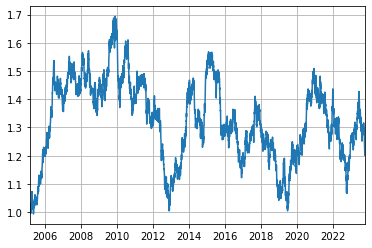

In [20]:
params =  [-.7, .1, .1, 0.2, .001, 0 , .05]
dt = 1/252
price_series = close
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
#print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
plt.plot(date[300:],v1[300:]/v1[300])
plt.grid(True)
plt.autoscale(axis='x', tight=True)

In [21]:
initial_guess = [-.7, .1, .1, 0.2, .0001, 0 , .05]  # [rho, kappa, theta, sigma, lambda, mu_j, sigma_j]
delta = 0.1  # The value you want to add and subtract
lower_bounds = [-0.9, 0.001, 0.001, .01, .001, 0.001, .01]
upper_bounds = [0.9, .8, .05, .01, .01, .005, .1]
bounds = list(zip(lower_bounds, upper_bounds))
print(bounds)

[(-0.9, 0.9), (0.001, 0.8), (0.001, 0.05), (0.01, 0.01), (0.001, 0.01), (0.001, 0.005), (0.01, 0.1)]


In [22]:
lb = lower_bounds
ub = upper_bounds

bounds = list(zip(lb,ub))
param1_min, param1_max = bounds[0]
param2_min, param2_max = bounds[1]
param3_min, param3_max = bounds[2]
param4_min, param4_max = bounds[3]
param5_min, param5_max = bounds[4]
param6_min, param6_max = bounds[5]
param7_min, param7_max = bounds[6]

print(bounds)
print(lb)


[(-0.9, 0.9), (0.001, 0.8), (0.001, 0.05), (0.01, 0.01), (0.001, 0.01), (0.001, 0.005), (0.01, 0.1)]
[-0.9, 0.001, 0.001, 0.01, 0.001, 0.001, 0.01]


In [23]:
!pip install deap
from deap import base, creator, tools, algorithms

# Create the 'creator' object
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)


# Perform parameter estimation using minimize
options = {'maxiter': 1000,  # Maximum number of iterations
           'maxfev': 500   # Maximum number of function calls
                     }

creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

creator.create("FitnessMin", base.Fitness, weights=(1.0,))

# Define the individual representation, which includes the five parameters
creator.create("Individual", list, fitness=creator.FitnessMin)

# Define the bounds for each parameter


# Create an individual with random values within the defined bounds
def create_individual():
    return [
        random.uniform(param1_min, param1_max),
        random.uniform(param2_min, param2_max),
        random.uniform(param3_min, param3_max),
        random.uniform(param4_min, param4_max),
        random.uniform(param5_min, param5_max),
        random.uniform(param6_min, param6_max),
        random.uniform(param7_min, param7_max),

    ]

# Example of creating an individual
individual = create_individual()
toolbox = base.Toolbox()
# Define parameter boundaries
#varbound = np.array([[-0.9, 0.9], [0.001, 5], [0.001, 2.0], [0.001, 2.0], [0.001, 5.0]])
#bounds = [(-.99, .99), (0.001,5.0), (.001, 2.0), (.001, 2.0), (.001,5.0)]

# Register functions for creating individuals and populations
nparams = 7
toolbox.register("attr_float", np.random.uniform, 0.01, .99)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=nparams)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register other DEAP functions
toolbox.register("mate", tools.cxBlend, alpha=0.2)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.05, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=4)

# Set the number of generations and other parameters for GA
ngen = 200
cxpb = 0.4  # Crossover probability
mutpb = 0.05  # Mutation probability

# Create a population of 10 individuals for GA with variable boundaries
population = toolbox.population(n=100)

# Define custom evaluation function for GA
def eval_individual(individual):
    params = individual
    fitness = likelihood1(params, price_series, dt)
    return (fitness,)  # Wrap the fitness value in a tuple

# Register the evaluate function in the toolbox
toolbox.register("evaluate", eval_individual)

# Manually assign fitness values to individuals in the population
for ind in population:
    ind.fitness.values = eval_individual(ind)

# Create a Hall of Fame object to store the best individual from GA
hof = tools.HallOfFame(1)

# Define the GA statistics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)

# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb, mutpb, ngen, stats=stats, halloffame=hof, verbose=True)

# Get the best individual from the genetic algorithm
best_individual_ga = hof[0]



C:\Users\mcnel\anaconda4\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\mcnel\anaconda4\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals	min      
0  	0     	-0.795957
1  	41    	-0.6849  
2  	47    	-0.672118
3  	46    	-0.667855
4  	47    	-0.672985
5  	42    	-0.665027
6  	47    	-0.662286
7  	46    	-0.660607
8  	54    	-0.654434
9  	37    	-0.648736
10 	35    	-0.649628
11 	33    	-0.645039
12 	44    	-0.643871
13 	39    	-0.653167
14 	42    	-0.642952
15 	54    	-0.642512
16 	37    	-0.646536
17 	41    	-0.64242 
18 	45    	-0.642306
19 	47    	-0.648609
20 	39    	-0.641863
21 	53    	-0.652005
22 	47    	-0.640856
23 	33    	-0.64056 
24 	52    	-0.656369
25 	33    	-0.649848
26 	47    	-0.639789
27 	28    	-0.639765
28 	42    	-0.63979 
29 	45    	-0.640121
30 	42    	-0.656037
31 	48    	-0.651436
32 	37    	-0.649238
33 	51    	-0.645972
34 	34    	-0.639587
35 	22    	-0.654034
36 	41    	-0.639194
37 	39    	-0.646705
38 	42    	-0.645606
39 	49    	-0.639068
40 	42    	-0.639044
41 	40    	-0.642199
42 	45    	-0.643247
43 	51    	-0.639304
44 	51    	-0.649764
45 	49    	-0.644857
46 	48    	-0

[0.4054048389785635, 2.2315025849148933, -0.0003302131237868062, 0.03950793340649644, 0.28117128538204156, 0.8519268251277081, 0.35626586604149146]
22.26059468178675
[[0.62801923]]


Text(0.5, 1.0, 'SVJD Process for Genetic Algorithm Estimation')

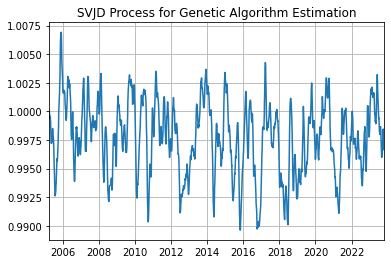

In [24]:
print(hof[0])
params = hof[0]
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
window_size = 20
start = 300
# Calculate the rolling window average
v_smooth = np.convolve(v1, np.ones(window_size) / window_size, mode='valid')
v_smooth = v_smooth
plt.plot(date[start+window_size-1:],v_smooth[start:]/v_smooth[start])
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('SVJD Process for Genetic Algorithm Estimation')

In [25]:
print(hof[0])

[0.4054048389785635, 2.2315025849148933, -0.0003302131237868062, 0.03950793340649644, 0.28117128538204156, 0.8519268251277081, 0.35626586604149146]


In [26]:
import numpy as np
from scipy.optimize import dual_annealing

# Define the objective function to minimize

# Define the bounds for each variable
initial_guess = hof[0]
lower_bounds = [-0.9, 1, 0.00011, .5, .1, 0.4, .0001]
upper_bounds = [0.1, 3, .05, 1.5, 1.5, .9, .1]
bounds = list(zip(lower_bounds, upper_bounds))

#lower_bounds = initial_guess * (1-delta)
#upper_bounds = initial_guess * (1+delta)
bounds = list(zip(lower_bounds, upper_bounds))

# Run dual_annealing
result = dual_annealing(
    func= likelihood,
    bounds=bounds,
    maxiter=200,
    args=(price_series, dt),  # Pass the long series as an argument
    initial_temp=100,
    seed= 76,

)

# Print the results
print("Optimal Solution:", result.x)
print("Optimal Value:", result.fun)

Optimal Solution: [-5.46988831e-01  3.00000000e+00  1.10000000e-04  6.43415705e-01
  2.54438655e-01  9.00000000e-01  1.00000000e-01]
Optimal Value: 0.6266336930974625


[-5.46988831e-01  3.00000000e+00  1.10000000e-04  6.43415705e-01
  2.54438655e-01  9.00000000e-01  1.00000000e-01]
22.10545399272634
[[0.62663369]]


Text(0.5, 1.0, 'SVJD Process for Simulated Annealing')

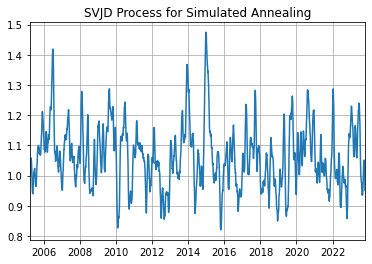

In [27]:
params = result.x
print(params)
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
window_size = 20
start = 300
# Calculate the rolling window average
v_smooth = np.convolve(v1, np.ones(window_size) / window_size, mode='valid')
v_smooth = v_smooth
plt.plot(date[start+window_size-1:],v_smooth[start:]/v_smooth[start])
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('SVJD Process for Simulated Annealing')

In [28]:
#!pip install pyswarm
import numpy as np
from pyswarm import pso

# Define the objective function to be minimized
params = result.x
initial_guess = params
lower_bounds = [-0.7, 1.5, 0.001, 1.0, .1, 0.1, .001]
upper_bounds = [.3, 3, .01, 2, .4, .5, .01]
bounds = list(zip(lower_bounds, upper_bounds))
bounds = list(zip(lower_bounds,  upper_bounds))


lb = lower_bounds
ub = upper_bounds
c1 = 1  # Cognitive parameter
c2 = 1  # Social parameter
w = 0.5  # Inertia weight
maxiter = 50 # Maximum number of iterations

# Perform PSO optimization with additional arguments and defined parameters
parameters, value = pso(likelihood, lb, ub, args=(price_series, dt), debug=True, swarmsize=50, maxiter=maxiter, phip=c1, phig=c2, omega=w)

No constraints given.
Best after iteration 1: [2.09743576e-01 2.48695220e+00 2.02363390e-03 1.01737251e+00
 1.10373274e-01 3.69651111e-01 9.06010699e-03] 0.6525609093962963
New best for swarm at iteration 2: [3.00000000e-01 2.31018263e+00 1.00000000e-03 1.00000000e+00
 1.53105161e-01 3.46060937e-01 1.00000000e-02] [[0.65240366]]
Best after iteration 2: [3.00000000e-01 2.31018263e+00 1.00000000e-03 1.00000000e+00
 1.53105161e-01 3.46060937e-01 1.00000000e-02] [[0.65240366]]
New best for swarm at iteration 3: [3.00000000e-01 2.44262401e+00 1.08015435e-03 1.00000000e+00
 1.34739386e-01 4.20738969e-01 9.60444750e-03] [[0.64922733]]
New best for swarm at iteration 3: [3.00000000e-01 2.83995064e+00 1.00000000e-03 1.00000000e+00
 1.09857506e-01 5.00000000e-01 1.00000000e-02] [[0.6447433]]
New best for swarm at iteration 3: [3.00000000e-01 2.83693023e+00 2.24087180e-03 1.00000000e+00
 1.87923772e-01 5.00000000e-01 1.00000000e-02] [[0.64304498]]
Best after iteration 3: [3.00000000e-01 2.8369302

Best after iteration 43: [3.00000000e-01 3.00000000e+00 1.00000000e-03 1.00000000e+00
 2.84572603e-01 5.00000000e-01 1.00000000e-02] [[0.63752038]]
Best after iteration 44: [3.00000000e-01 3.00000000e+00 1.00000000e-03 1.00000000e+00
 2.84572603e-01 5.00000000e-01 1.00000000e-02] [[0.63752038]]
Best after iteration 45: [3.00000000e-01 3.00000000e+00 1.00000000e-03 1.00000000e+00
 2.84572603e-01 5.00000000e-01 1.00000000e-02] [[0.63752038]]
Best after iteration 46: [3.00000000e-01 3.00000000e+00 1.00000000e-03 1.00000000e+00
 2.84572603e-01 5.00000000e-01 1.00000000e-02] [[0.63752038]]
Best after iteration 47: [3.00000000e-01 3.00000000e+00 1.00000000e-03 1.00000000e+00
 2.84572603e-01 5.00000000e-01 1.00000000e-02] [[0.63752038]]
Best after iteration 48: [3.00000000e-01 3.00000000e+00 1.00000000e-03 1.00000000e+00
 2.84572603e-01 5.00000000e-01 1.00000000e-02] [[0.63752038]]
Best after iteration 49: [3.00000000e-01 3.00000000e+00 1.00000000e-03 1.00000000e+00
 2.84572603e-01 5.00000000

In [29]:
print(parameters)

[3.00000000e-01 3.00000000e+00 1.00000000e-03 1.00000000e+00
 2.84572603e-01 5.00000000e-01 1.00000000e-02]


[3.00000000e-01 3.00000000e+00 1.00000000e-03 1.00000000e+00
 2.84572603e-01 5.00000000e-01 1.00000000e-02]
20.920294205680555
[[0.63752038]]


Text(0.5, 1.0, 'SVJD Process for Partical Swarm Estimation')

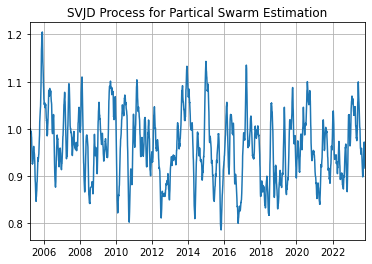

In [30]:
params = parameters
print(params)
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
window_size = 20
start = 300
# Calculate the rolling window average
v_smooth = np.convolve(v1, np.ones(window_size) / window_size, mode='valid')
v_smooth = v_smooth
plt.plot(date[start+window_size-1:],v_smooth[start:]/v_smooth[start])
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('SVJD Process for Partical Swarm Estimation')

$\textbf{Options for Minimzation}$

- 'BFGS': Broyden-Fletcher-Goldfarb-Shanno (BFGS) algorithm is a quasi-Newton method used for unconstrained optimization. It approximates the Hessian matrix using gradient information.

- 'L-BFGS-B': Limited-memory Broyden-Fletcher-Goldfarb-Shanno (L-BFGS-B) is a variant of BFGS for bounded variable problems. It is suitable for problems with both constraints and bounds.

- 'Nelder-Mead': Nelder-Mead simplex algorithm is a derivative-free optimization method used for unconstrained problems. It is suitable for problems where derivatives are not available or difficult to compute.

- 'Powell': Powell’s method is a conjugate direction method. It doesn't require derivatives, and it can be used for both constrained and unconstrained optimization.

- 'CG': Conjugate Gradient method is suitable for unconstrained optimization. It's often used when the objective function is quadratic.

- 'Newton-CG': Newton-Conjugate Gradient method is used for unconstrained optimization. It requires the Hessian (second derivative) of the objective function.

- 'TNC': Truncated Newton Conjugate-Gradient method is for bounded constrained optimization. It approximates the Hessian using finite differences.

- 'trust-ncg': Trust-Region Newton-Conjugate Gradient method is used for unconstrained optimization. It requires the Hessian of the objective function.

- 'trust-exact': Trust-Region Exact method is a trust-region algorithm for unconstrained optimization that uses exact second derivatives (Hessian).

- 'trust-krylov': Trust-Region Krylov method is a trust-region algorithm for unconstrained optimization that uses an approximate Hessian.

- 'trust-constr': Trust Region Constrained method is for constrained optimization with bounds and linear constraints. It uses a trust-region approach.

- 'dogleg': Dogleg method is for unconstrained optimization. It combines steepest-descent and trust-region methods.

- 'trust-ncg': Trust-Region Newton-Conjugate Gradient method is for unconstrained optimization. It requires the Hessian of the objective function.

- 'trust-krylov': Trust-Region Krylov method is for unconstrained optimization. It uses Krylov subspace methods to approximate the Hessian.

- 'trust-region': Generic trust-region method that allows you to specify the Hessian approximation method using the hess parameter.

- 'basinhopping': Basin-Hopping algorithm is a global optimization method that combines local minimization with random sampling of starting points.

- 'shgo': SHGO (Simplicial Homology Global Optimization) is a global optimization method for both constrained and unconstrained problems.

In [31]:
#  params: [rho, kappa, theta, sigma, lambda_J, mu_J, sigma_J]
#import numpy as np
np.seterr(over='ignore', divide='ignore', invalid='ignore')  # Ignore overflow and other warnings

initial_guess = parameters
delta = 0.2 # The value you want to add and subtract
lower_bound = [-.7, 1.5, .00001, .8, .01, .4, .001]

upper_bound = [1.1, 4, .01, 1.5, .4, .7, .02]
bounds = list(zip(lower_bound, upper_bound))

result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='Powell', options={'maxiter':200})

#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='Powell', options={'maxiter':200})
#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='TNC', options={'maxiter':200})
#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='SLSQP', options={'maxiter':200})
#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='COBYLA', options={'maxiter':200})
#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='L-BFGS-B', options={'maxiter':200})
#initial_guess = result.x
#initial_guess = result.x
#result = minimize(likelihood, initial_guess, bounds= bounds, args=(price_series, dt), method='CG', options={'maxiter':200})

# Extract estimated parameters
rho_est, kappa_est, theta_est, sigma_est, lambda_J_est, mu_J_est, sigma_J_est = result.x
print(f"Estimated Parameters:")
print(f"Rho: {rho_est}")
print(f"Kappa: {kappa_est}")
print(f"Theta: {theta_est}")
print(f"Sigma: {sigma_est}")
print(f"lambda: {lambda_J_est}")
print(f"mu_J: {mu_J_est}")
print(f"sigma_J: {sigma_J_est}")






Estimated Parameters:
Rho: 0.382618164577501
Kappa: 3.999941094957579
Theta: 5.789154754267669e-05
Sigma: 0.8000571492475509
lambda: 0.28108820084544156
mu_J: 0.6999493232591723
sigma_J: 0.019940993219712305


[3.82618165e-01 3.99994109e+00 5.78915475e-05 8.00057149e-01
 2.81088201e-01 6.99949323e-01 1.99409932e-02]
21.825101005742887
[[0.62181557]]


Text(0.5, 1.0, 'SVJD Process for BFGS Gradient Method')

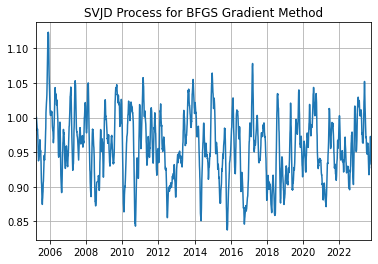

In [32]:
params = result.x
print(params)
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
window_size = 20
start = 300
# Calculate the rolling window average
v_smooth = np.convolve(v1, np.ones(window_size) / window_size, mode='valid')
v_smooth = v_smooth
plt.plot(date[start+window_size-1:],v_smooth[start:]/v_smooth[start])
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('SVJD Process for BFGS Gradient Method')


(array([1.000e+00, 0.000e+00, 0.000e+00, 1.700e+01, 4.486e+03, 6.220e+02,
        4.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([-22.30502444, -17.67808149, -13.05113855,  -8.4241956 ,
         -3.79725265,   0.82969029,   5.45663324,  10.08357619,
         14.71051913,  19.33746208,  23.96440503]),
 <BarContainer object of 10 artists>)

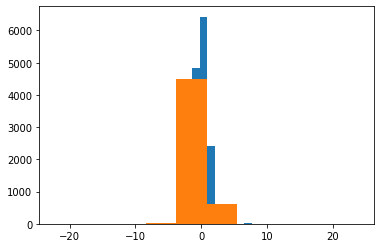

In [33]:
actual_returns = np.diff(np.log(price_series))

simulated_returns = simulated_returns[1:]
plt.hist(simulated_returns/np.std(simulated_returns))
plt.hist(actual_returns/np.std(actual_returns))



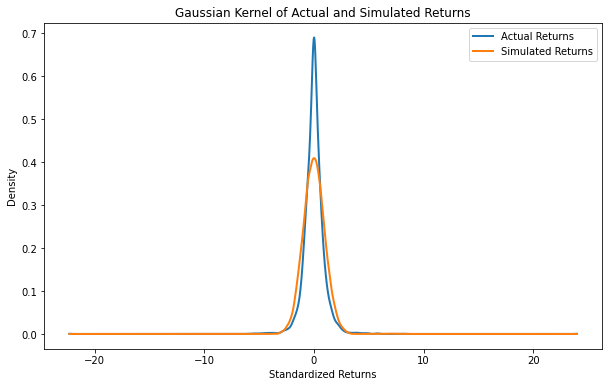

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming you have actual_returns and simulated_returns data
actual_returns = np.diff(np.log(price_series))
simulated_returns = simulated_returns[1:]

# Calculate standardized returns
actual_returns_std = actual_returns / np.std(actual_returns)
simulated_returns_std = simulated_returns / np.std(simulated_returns)

# Create a density estimator for actual_returns
actual_kde = gaussian_kde(actual_returns_std)

# Create a density estimator for simulated_returns
simulated_kde = gaussian_kde(simulated_returns_std)

# Create a range of values for the x-axis
x = np.linspace(min(min(actual_returns_std), min(simulated_returns_std)),
                max(max(actual_returns_std), max(simulated_returns_std)), 1000)

# Plot KDE for actual_returns
plt.figure(figsize=(10, 6))
plt.plot(x, actual_kde(x), label='Actual Returns', linewidth=2)

# Plot KDE for simulated_returns
plt.plot(x, simulated_kde(x), label='Simulated Returns', linewidth=2)

# Set labels and legend
plt.xlabel('Standardized Returns')
plt.ylabel('Density')
plt.legend()
plt.title('Gaussian Kernel of Actual and Simulated Returns')

# Show the plot
plt.show()






In [35]:
import torch
import torch.nn.functional as F



def torch_likelihood(params, price_series, dt):
    import torch
    import torch.nn.functional as F
    #if not isinstance(params, torch.Tensor):
    #    params = torch.tensor(params, dtype=torch.float64)
    #params = params.detach().numpy()  # Convert to NumPy array if needed
    simulated_price, simulated_returns, v1, sse, rsq, error = heston_model(params, price_series, dt)
    #price_series = torch.tensor(price_series, dtype=torch.float64, requires_grad = False)
    actual_returns = 100 * torch.diff(torch.log(price_series))
    model_returns = 100 * simulated_returns

    model_returns =  torch.tensor(model_returns, dtype=torch.float64, requires_grad=False)
    T = len(actual_returns)
    residuals = error
    residuals = torch.tensor(residuals, dtype=torch.float64, requires_grad = False)
    v1 =  torch.tensor(v1, dtype=torch.float64, requires_grad = False)
    dt = torch.tensor(dt, dtype=torch.float64, requires_grad = False)
    Log_likelihood = -0.5 * torch.sum(residuals**2) - 0.5 * torch.tensor(np.pi, dtype=torch.float64, requires_grad = False) * torch.sum(v1)

    # Calculate moments using PyTorch operations
    actual_moments = torch.tensor([torch.mean(actual_returns), torch.mean(actual_returns**2),
                                    torch.mean(actual_returns**3), torch.mean(actual_returns**4)], dtype=torch.float64, requires_grad = False)
    model_moments = torch.tensor([torch.mean(model_returns), torch.mean(model_returns**2),
                                   torch.mean(model_returns**3), torch.mean(model_returns**4)], dtype=torch.float64, requires_grad = False)

    actual_moments = actual_moments.view(1, 4)
    model_moments = model_moments.view(1, 4)

    # Calculate autocorrelations using PyTorch operations
    actual_returns_sq = actual_returns**2
    model_returns_sq = model_returns**2

    max_lag = 5

    actual_autocorr = []
    actual_autocorr_sq = []
    model_autocorr = []
    model_autocorr_sq = []






    for lag in range(1, max_lag + 1):
    # Calculate cross-correlation using conv1d for actual_returns

        shifted_model_returns = torch.roll(model_returns, shifts=lag, dims=0)
        cross_corr_model = F.conv1d(model_returns.view(1, 1, -1), shifted_model_returns.view(1, 1, -1).flip(2), padding=0)
        model_autocorr1 = cross_corr_model.squeeze() / len(model_returns)
        model_autocorr.append(model_autocorr1)

        shifted_actual_returns = torch.roll(actual_returns, shifts=lag, dims=0)
        cross_corr_actual = F.conv1d(actual_returns.view(1, 1, -1), shifted_actual_returns.view(1, 1, -1).flip(2), padding=0)
        actual_autocorr1 = cross_corr_actual.squeeze() / len(actual_returns)
        actual_autocorr.append(model_autocorr1)

        shifted_model_returns_sq = torch.roll(model_returns_sq, shifts=lag, dims=0)
        cross_corr_model_sq = F.conv1d(model_returns_sq.view(1, 1, -1), shifted_model_returns_sq.view(1, 1, -1).flip(2), padding=0)
        model_autocorr1_sq = cross_corr_model_sq.squeeze() / len(model_returns_sq)
        model_autocorr_sq.append(model_autocorr1_sq)

        shifted_actual_returns_sq = torch.roll(actual_returns_sq, shifts=lag, dims=0)
        cross_corr_actual_sq = F.conv1d(actual_returns_sq.view(1, 1, -1), shifted_actual_returns_sq.view(1, 1, -1).flip(2), padding=0)
        actual_autocorr1_sq = cross_corr_actual_sq.squeeze() / len(actual_returns_sq)
        actual_autocorr_sq.append(model_autocorr1_sq)






    threshold = 2.576 * torch.std(actual_returns)
    actual_jumps, actual_jump_size = count_jumps_and_average_jump_size(actual_returns, threshold)
    model_jumps, model_jump_size = count_jumps_and_average_jump_size(model_returns, threshold)
    import torch

# Convert Pandas Series to PyTorch tensors
    model_jumps = torch.tensor(model_jumps, dtype=torch.float64).clone().detach()
    model_jump_size = torch.tensor(model_jump_size, dtype=torch.float64).clone().detach()
    actual_jumps = torch.tensor(actual_jumps, dtype=torch.float64).clone().detach()
    actual_jump_size = torch.tensor(actual_jump_size, dtype=torch.float64).clone().detach()

    ACTUAL_MOMENTS = [actual_moments, actual_jumps, actual_jump_size, actual_autocorr, actual_autocorr_sq]
    MODEL_MOMENTS = [model_moments, model_jumps, model_jump_size, model_autocorr, model_autocorr_sq]

    # Concatenate all arrays within ACTUAL_MOMENTS and MODEL_MOMENTS horizontally
 #   ACTUAL_MOMENTS = torch.cat([arr.view(1, -1) if len(arr.shape) == 1 else arr for arr in ACTUAL_MOMENTS], dim=1)
 #   MODEL_MOMENTS = torch.cat([arr.view(1, -1) if len(arr.shape) == 1 else arr for arr in MODEL_MOMENTS], dim=1)

    ACTUAL_MOMENTS = [arr if isinstance(arr, torch.Tensor) else torch.tensor(arr) for arr in ACTUAL_MOMENTS]
    MODEL_MOMENTS = [arr if isinstance(arr, torch.Tensor) else torch.tensor(arr) for arr in MODEL_MOMENTS]

# Concatenate all tensors within ACTUAL_MOMENTS and MODEL_MOMENTS horizontally
    ACTUAL_MOMENTS = torch.cat([arr.view(1, -1) for arr in ACTUAL_MOMENTS], dim=1)
    MODEL_MOMENTS = torch.cat([arr.view(1, -1) for arr in MODEL_MOMENTS], dim=1)

    ERROR_MOMENTS = ACTUAL_MOMENTS - MODEL_MOMENTS
    num_moments = ERROR_MOMENTS.shape[1]
    #ERROR_MOMENTS = torch.tensor([ERROR_MOMENTS])
    ERROR_MOMENTS_T = ERROR_MOMENTS.t()

# Compute the covariance matrix
    COVARIANCE_MOMENTS = torch.mm(ERROR_MOMENTS_T, ERROR_MOMENTS_T.t())

    SIGMA_MOMENTS = torch.mm(ERROR_MOMENTS, ERROR_MOMENTS.t())
    SIGMA_MOMENTS1 = torch.diag(torch.diag(SIGMA_MOMENTS))
    SIGMA_MOMENTS2 = torch.sqrt(SIGMA_MOMENTS1)
    SIGMA_MOMENTS3 = torch.inverse(SIGMA_MOMENTS2)
    ERROR_TOTAL1 = torch.log(torch.mm(ERROR_MOMENTS.t(), torch.mm(SIGMA_MOMENTS3, ERROR_MOMENTS)))
    ERROR_TOTAL2 = torch.log(torch.sum(ERROR_MOMENTS**2))
    log_likelihood1 = ERROR_TOTAL1.sum()  # Adjust as per your likelihood function
    log_likelihood = log_likelihood1.clone().detach().requires_grad_(True)

    return log_likelihood  # Return negative log-likelihood for minimization


In [36]:
#!pip install torch

from torch.optim import Adam
from torch.optim import SGD


# Define your objective function with additional arguments

params = result.x
# Additional data and parameters
params = torch.tensor(params, requires_grad=True, dtype=torch.float64)
price_series = torch.tensor(price_series, dtype=torch.float64, requires_grad = False)

# Create an Adam optimizer
#optimizer = Adam([params], lr=0.01)  # Wrap params in a list
optimizer = SGD([params], lr=0.01)
#optimizer = RMSprop([params], lr=0.01)
#optimizer = Adagrad([params], lr=0.01)
#optimizer = Adadelta([params], lr=1.0)
#optimizer  = LBFGS([params], lr=0.01)
#optimizer =  SparseAdam([params], lr=0.001)
#optimizer = AdamW([params], lr=0.01)
#optimizer  = Rprop([params], lr=0.01)

# Number of optimization steps
num_steps = 500

# Optimization loop
for _ in range(num_steps):
    optimizer.zero_grad()
    loss = torch_likelihood(params, price_series, dt)
    loss.backward()
    optimizer.step()

# Extract the optimized parameters as a NumPy array
optimized_params = params.detach().numpy()

# Print the result
print("Optimized parameters:", optimized_params)

C:\Users\mcnel\AppData\Local\Temp\ipykernel_7488\130643768.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_jump_size = torch.tensor(model_jump_size, dtype=torch.float64).clone().detach()
C:\Users\mcnel\AppData\Local\Temp\ipykernel_7488\130643768.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  actual_jump_size = torch.tensor(actual_jump_size, dtype=torch.float64).clone().detach()


Optimized parameters: [3.82618165e-01 3.99994109e+00 5.78915475e-05 8.00057149e-01
 2.81088201e-01 6.99949323e-01 1.99409932e-02]


In [39]:
print(optimized_params)

[3.82618165e-01 3.99994109e+00 5.78915475e-05 8.00057149e-01
 2.81088201e-01 6.99949323e-01 1.99409932e-02]


[3.82618165e-01 3.99994109e+00 5.78915475e-05 8.00057149e-01
 2.81088201e-01 6.99949323e-01 1.99409932e-02]
21.97941193057085
[[0.62181557]]


Text(0.5, 1.0, 'SVJD Process for Adam - Tensor Flow Gradient Method')

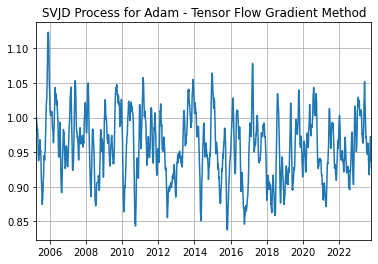

In [41]:
params = optimized_params
print(params)
simulated_price, simulated_returns, v1, sse, rsq,error = heston_model(params, price_series, dt)
print(sse)
lsq = likelihood(params, price_series, dt)
print(lsq)
window_size = 20
start = 300
# Calculate the rolling window average
v_smooth = np.convolve(v1, np.ones(window_size) / window_size, mode='valid')
v_smooth = v_smooth
plt.plot(date[start+window_size:],v_smooth[start:]/v_smooth[start])
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('SVJD Process for Adam - Tensor Flow Gradient Method')




In [42]:
def heston_model_jumps(params, price_series, dt):
    """
    Heston model simulation for parameter estimation
    params: [rho, kappa, theta, sigma, lambda_J, mu_J, sigma_J]
    price_series: Asset price series
    dt: Time step
    """
    if isinstance(params, torch.Tensor):
        params = params.detach().numpy()
    if isinstance(price_series, torch.Tensor):
        price_series = price_series.detach().numpy()
    rho1, kappa, theta, sigma,lambda_J, mu_J, sigma_J = params
    rho = np.tanh(rho1)
    T = len(price_series)
    TT =   T + 10000
    v = np.zeros(TT)
    log_returns = np.log(price_series[1:]/price_series[:-1])
    mu = (1 + 0.03)**dt - 1
    theta = np.sqrt(theta**2)
    v[0] = theta
    simulated_returns = np.zeros(TT)
    sigma_J = np.sqrt(sigma_J**2)
    lambda_J = np.sqrt(lambda_J**2)
    sigma = np.sqrt(sigma**2)
    rng = np.random.default_rng(seed=76)
    jump_times = rng.poisson(lambda_J *dt, TT)
    np.random.seed(1947)
    random_matrix = np.random.randn(TT, 3) * np.sqrt(dt)
    dW1 = random_matrix[:,0]
    dW2a = random_matrix[:,1]
    dW2 = rho*(dW1) + (1-rho)* dW2a
    JS = random_matrix[:,2]
    jump_sizes = JS * sigma_J + mu_J



    for t in range(1, TT):
        simulated_returns[t] = mu + np.sqrt(v[t - 1]) * dW1[t]
        if jump_times[t] > 0:
            simulated_returns[t] += jump_sizes[t]
        v[t] = v[t - 1] + kappa * (theta - v[t - 1]) * dt + sigma * np.sqrt(v[t - 1]) * dW2[t]
        v[t] = np.log(1.0 + np.exp(v[t]))

    simulated_price = np.exp(np.cumsum(simulated_returns))
    actual_returns = log_returns
    TTA = len(actual_returns)
    #error = (simulated_returns[1:T] - actual_returns)
    #sse = np.sum(error**2)
    rsq = np.var(simulated_returns[:TTA]) / (np.var(actual_returns[:TTA])+.0001)
    v1 = v[:TTA]
    error = (simulated_returns[:TTA] -actual_returns[:TTA])/np.sqrt(v1[:TTA]+.0001)
    sse = np.sum(error**2)
    return simulated_price, simulated_returns, v1, sse, rsq,error, jump_times, jump_sizes

In [43]:
simulated_price, simulated_returns, v1, sse, rsq,error, jump_times, jump_sizes =heston_model_jumps(params, price_series, dt)

In [44]:
print(len(jump_sizes))

15132


In [51]:
jump_sizes1 = jump_sizes[:len(v1)]
jump_times1 = jump_times[:len(v1)]


In [52]:
JUMPER1 =  jump_sizes1 * jump_times1

Text(0.5, 1.0, 'Predicted Jumps from SVJD Model')

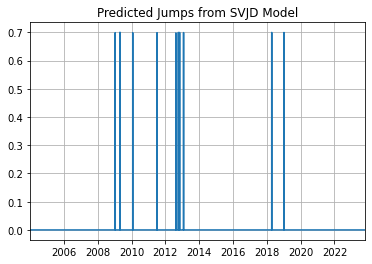

In [57]:
plt.plot(date[1:], JUMPER1)
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.title('Predicted Jumps from SVJD Model')